In [7]:
# 运行此段做数据准备
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
# 做傅里叶变化前将数据转化为浮点型
srcImg = cv.imread('../images/flower.png', 0).astype(float)

Text(0.5, 1.0, 'phase')

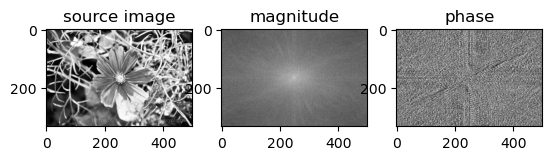

In [8]:
'''
# 展示原图像与幅度谱和相位谱
'''

# 采用flags=cv.DFT_COMPLEX_OUTPUT输出形式，这样cv.dft输出结果为实部和虚部组成的三维数组，同时结果具有共轭对称性，形状为(rows, cols, 2)，src_dft[:, :, 0]为实部，src_dft[:, :, 1]为虚部
src_dft = cv.dft(srcImg, flags=cv.DFT_COMPLEX_OUTPUT)
# 作fftshift后，零频率分量转移到图像中心
src_dft_shift = np.fft.fftshift(src_dft)
# mag对应幅值图像，傅里叶系数的动态范围太大，无法显示在屏幕上，将其对数化后才能正常显示，phase对应相位图像
mag = cv.magnitude(src_dft_shift[:, :, 0], src_dft_shift[:, :, 1])
mag_log = np.log(mag)
phase = cv.phase(src_dft_shift[:, :, 0], src_dft_shift[:, :, 1])
# 将幅度归一化，此处是为增加数据可读性，即使不做归一化，作图时plt.imshow函数也会作归一处理, 而对相位归一处理后会破环可读性
cv.normalize(mag_log, mag_log, 0, 1, cv.NORM_MINMAX)

# 展示原图像的幅度谱与相位谱
figure1 = plt.figure(1)
plt.subplot(131)
plt.imshow(srcImg, "gray")
plt.title("source image")
plt.subplot(132)
plt.imshow(mag_log, "gray")
plt.title("magnitude")
plt.subplot(133)
plt.imshow(phase, "gray")
plt.title("phase")


Text(0.5, 1.0, 'magnitude = A')

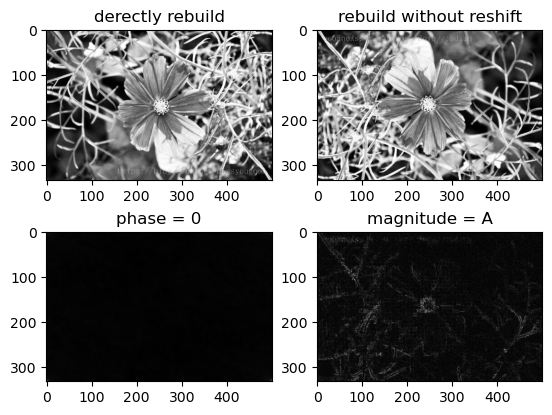

In [12]:
'''
# 改变图像幅度谱和相位谱
'''

# 图像1：重建原图
# 采用flags=cv.DFT_REAL_OUTPUT输出形式，IDFT输出结果通常为复数数组（形状为(srcImg.shape[0], srcImg.shape[1], 2)），传递此flags参数后，函数将会假定我们的输入具有共轭对称性，这样我们的IDFT输出结果为实数数组
img_rebuild_1 = cv.idft(src_dft, flags=cv.DFT_REAL_OUTPUT)

# 图像2：进行fftshift后重建图像
# 由于src_dft_shift不具有共轭对称性，只能以复数数组形式输出
# fftshift还原的图像含有虚部，需要求幅值来恢复图像
img_idft_2 = cv.idft(src_dft_shift, flags=cv.DFT_COMPLEX_INPUT)
img_rebuild_2 = cv.magnitude(img_idft_2[:, :, 0], img_idft_2[:, :, 1])

# 图像3:相位谱置0后重建图像
# 首先要由幅度谱和相位谱还原出实部和虚部，由于相位为0，所以实部等于幅值，虚部等于0
img_dft_3 = np.stack((mag, np.zeros(srcImg.shape)), axis=2)
img_idft_3 = cv.idft(img_dft_3, flags=cv.DFT_COMPLEX_INPUT)
# img_rebuild_3 = img_idft_3[:, :, 0]
img_rebuild_3 = cv.magnitude(img_idft_3[:, :, 0], img_idft_3[:, :, 1])

# 图像4:幅度谱设置为A后重建图像
# 首先要由幅度谱和相位谱还原出实部和虚部
A = 1000
img_dft_4 = np.stack((A*np.cos(phase), A*np.sin(phase)), axis=2)
img_idft_4 = cv.idft(img_dft_4, flags=cv.DFT_COMPLEX_INPUT)
# 这里只输出实部的话没有有效信息，需要求幅值来恢复图像
# img_rebuild_4 = img_idft_4[:, :, 0]
img_rebuild_4 = cv.magnitude(img_idft_4[:, :, 0], img_idft_4[:, :, 1])

# 将图像归一化
img_rebuild_1 = cv.normalize(img_rebuild_1, None, 0, 1, cv.NORM_MINMAX)
img_rebuild_2 = cv.normalize(img_rebuild_2, None, 0, 1, cv.NORM_MINMAX)
img_rebuild_3 = cv.normalize(img_rebuild_3, None, 0, 1, cv.NORM_MINMAX)
img_rebuild_4 = cv.normalize(img_rebuild_4, None, 0, 1, cv.NORM_MINMAX)

#作图
figure2 = plt.figure(2)
plt.subplot(221)
plt.imshow(img_rebuild_1, "gray")
plt.title("derectly rebuild")
plt.subplot(222)
plt.imshow(img_rebuild_2, "gray")
plt.title("rebuild without reshift")
plt.subplot(223)
plt.imshow(img_rebuild_3, "gray")
plt.title("phase = 0")
plt.subplot(224)
plt.imshow(img_rebuild_4, "gray")
plt.title("magnitude = A")

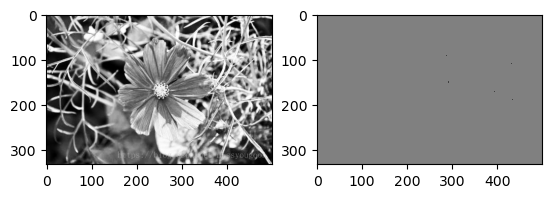

In [10]:
# 将src_dft逆变换结果也替换成复数数组，即使只输出实部也能复原图像
img_test_1 = cv.idft(src_dft, flags=cv.DFT_COMPLEX_INPUT)
cv.normalize(img_test_1, img_test_1, 0, 1, cv.NORM_MINMAX)
plt.subplot(121)
plt.imshow(img_test_1[:, :, 0], "gray")
# src_dft_shift做逆变换后不能, 逆变换结果img_test_2虚部也含有图像的有效信息
img_test_2 = img_idft_2
cv.normalize(img_test_2, img_test_2, 0, 1, cv.NORM_MINMAX)
plt.subplot(122)
plt.imshow(img_test_2[:, :, 0], "gray")

从以上实验中可以得出以下结论：

幅度谱中主要包含了图片能量的分布，在对原图像dft变换结果进行了fftshift后，可以看出图片能量主要集中在图像中心区域，也即是低频区域(实验中做了对数延展，使得低频向高频的过度变得平缓)，同时，幅度谱包含的图片信息少，破坏了幅度谱后，仍然能够还原出图片轮廓；相对的，而破坏了相位谱后，无法复原有效信息